P => Piecewise Linear Contrast Stretching

GHE => Global Histogram Equalization

CLAHE => Contrast Limited Adaptive Histogram Equalization

# Function label and jpg and png

In [1]:
import os
import glob
import keras
import sklearn
import cv2 as cv2
import numpy as np
import pandas as pd
import PIL as Image
import seaborn as sns
import pathlib as path
import tensorflow as tf
import matplotlib as mpl
from datetime import datetime
import matplotlib.image as img
from keras import backend as k
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils 
#from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
from keras.layers.convolutional import  MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU,Flatten,Activation, GlobalAveragePooling2D, Input
%matplotlib inline

In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['acc']
    temp_vloss = temph['val_acc']
    temp_vacc = temph['val_acc']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index
    # Print the result from the last epoch
    print('Highest validation accuracy in Epoch: %s'%str(max_index+1))
    print('Train accuracy: %s'%temp_acc[max_index])
    print('Validation accuracy: %s'%temp_vacc[max_index])
    print('--------------------------------------------------')
    print('Last train Epoch')
    print('Train accuracy: %s'%history.history['acc'][-1])
    print('Validation accuracy: %s'%history.history['val_acc'][-1])

    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,verbose=True)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    #labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [3]:
from tqdm.notebook import tqdm
import os, fnmatch
from keras import backend as K
from pathlib import Path
# change sub directory in list
def dirToList(dir_path):
  
  #get path create list
  pth = os.listdir(path=dir_path)
  lst_dir = []

  for s in pth:
    temp = str(dir_path + '\\' + s + '\\')
    lst_dir.append(temp)
  
  #remove .csv
  for i in tqdm(range(len(lst_dir))):
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'csv/':
      lst_dir.pop(i-1)
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'md/':
      lst_dir.pop(i-1)

  return lst_dir
# map path to name
def mapName(lab_list, lab_dict):
  temp = []
  for i in tqdm(range(len(lab_list))):
    key_label = lab_dict[lab_list[i]]
    temp.append(key_label)
  return temp

#### label

In [4]:
header_list = ["Type", "Description"]
md = pd.read_csv('C:\\Users\\CPE\\Desktop\\senior2023\\fco metdata.csv', names=header_list)
md

,Type,Description
0,ce,Cemento
1,os,Ossifying
2,fi,Fibrous


In [5]:
label_dict = dict(zip(md['Type'], md['Description']))
label_dict

{'ce': 'Cemento', 'os': 'Ossifying', 'fi': 'Fibrous'}

#### Import model

##### model inceptionresnetv2

In [6]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [37]:
def def_model():
    model = InceptionResNetV2(
    include_top=False, 
    input_shape=(224, 224, 3)
      )
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
  #full_conn = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(3, activation='softmax')(flat1)
	# define new model
    model = Model(inputs=model.inputs, outputs=output)
	# compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.save('/content/model/InceptionResNetV21.h5')
    model.summary()
    return model

##### model xception

In [8]:
#load pre trained Xception model
model_xcep1 = keras.applications.Xception(weights='imagenet',include_top=True, input_shape=(299,299,3),classifier_activation=None)

In [9]:
for layer in model_xcep1.layers:
    layer.trainable = False
x = Flatten() (model_xcep1.output)
prediction1 = Dense(3, activation = 'softmax')(x)
xcep1_model = Model(inputs = model_xcep1.input, outputs = prediction1)
xcep1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

##### model efficentnetb2

In [10]:
from keras.applications.efficientnet import EfficientNetB2

In [11]:
model_effi = tf.keras.applications.efficientnet.EfficientNetB2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(260,260,3),
    classifier_activation='softmax'
)
for layer in model_effi.layers:
    layer.trainable = False
x = Flatten() (model_effi.output)
prediction1 = Dense(3, activation = 'softmax')(x)
effi1_model = Model(inputs = model_effi.input, outputs = prediction1)
effi1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

# Gray + P + GHE

### Train

In [12]:
sub_dir_train_p_ghe = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell')
print(sub_dir_train_p_ghe)

sub_dir_train_Path_p_ghe = Path('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell')
all_filepaths_train_p_ghe = list(sub_dir_train_Path_p_ghe.glob(r'**\\*.png'))
all_filepaths_train_p_ghe

  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell\\ce\\', 'C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell\\fi\\', 'C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell\\os\\']


[WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_002_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_003_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_004_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_005_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_006_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_007_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_008_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_009_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_010_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/train_cell/ce/ce_011_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior20

In [13]:
all_path_p_ghe = []
all_index_p_ghe= []
for i in tqdm(range(len(sub_dir_train_p_ghe))):
  temp_p_ghe = fnmatch.filter(os.listdir(sub_dir_train_p_ghe[i]), "*.png")
  all_path_p_ghe.append(temp_p_ghe)
all_path_con_p_ghe =[item for sublist in all_path_p_ghe for item in sublist]
for i in tqdm(range(len(all_path_con_p_ghe))):
  index_p_ghe = all_path_con_p_ghe[i][:2]
  all_index_p_ghe.append(index_p_ghe)

all_path_map_train_p_ghe = mapName(all_index_p_ghe, label_dict)
all_path_map_train_p_ghe[:10]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

['Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento']

In [14]:
all_filepaths_p_ghe_df = pd.Series(all_filepaths_train_p_ghe , name = 'filepath').astype(str)
all_path_map_p_ghe_df = pd.Series(all_path_map_train_p_ghe, name = 'label')

all_p_ghe_df = pd.concat([all_filepaths_p_ghe_df, all_path_map_p_ghe_df], axis = 1)
print(all_p_ghe_df.shape)

all_p_ghe_df.head()

(449, 2)


,filepath,label
0,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
1,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
2,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
3,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
4,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento


### Test

In [15]:
sub_dir_test_p_ghe = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell')
print(sub_dir_test_p_ghe)

sub_dir_test_Path_p_ghe = Path('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell')
all_filepaths_test_p_ghe = list(sub_dir_test_Path_p_ghe.glob(r'**\\*.png'))
all_filepaths_test_p_ghe

  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\ce\\', 'C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\fi\\', 'C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\os\\']


[WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_002_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_003_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_004_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_005_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_006_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_007_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_008_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_009_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_010_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_GHE/test_cell/ce/ce_011_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray_P_G

In [16]:
all_path_test_p_ghe = []
all_index_test_p_ghe = []
for i in tqdm(range(len(sub_dir_test_p_ghe))):
  temp_p_ghe = fnmatch.filter(os.listdir(sub_dir_test_p_ghe[i]), "*.png")
  all_path_test_p_ghe.append(temp_p_ghe)
all_path_test_con_p_ghe =[item for sublist in all_path_test_p_ghe for item in sublist]
for i in tqdm(range(len(all_path_test_con_p_ghe))):
  index_test_p_ghe = all_path_test_con_p_ghe[i][:2]
  all_index_test_p_ghe.append(index_test_p_ghe)

all_path_test_map_p_ghe= mapName(all_index_test_p_ghe, label_dict)
print(all_path_test_map_p_ghe[:10])

all_filepaths_test_df_p_ghe = pd.Series(all_filepaths_test_p_ghe, name = 'filepath').astype(str)
all_path_test_map_df_p_ghe = pd.Series(all_path_test_map_p_ghe, name = 'label')

all_test_df_p_ghe = pd.concat([all_filepaths_test_df_p_ghe, all_path_test_map_df_p_ghe], axis = 1)
all_test_df_p_ghe.shape


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

['Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento']


(45, 2)

In [17]:
all_test_df_p_ghe

,filepath,label
0,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
1,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
2,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
3,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
4,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
5,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
6,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
7,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
8,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento
9,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tes...,Cemento


### Validation

In [18]:
ce_train_data_p_ghe = all_p_ghe_df.loc[all_p_ghe_df['label'] == label_dict['ce']]
fi_train_data_p_ghe = all_p_ghe_df.loc[all_p_ghe_df['label'] == label_dict['fi']]
os_train_data_p_ghe = all_p_ghe_df.loc[all_p_ghe_df['label'] == label_dict['os']]

ce_tr_p_ghe, ce_va_p_ghe = train_test_split(ce_train_data_p_ghe, test_size = .1)
fi_tr_p_ghe, fe_va_p_ghe = train_test_split(fi_train_data_p_ghe, test_size = .45)
os_tr_p_ghe, os_va_p_ghe = train_test_split(os_train_data_p_ghe, test_size = .75)

df_train_p_ghe = pd.concat([ce_tr_p_ghe,fi_tr_p_ghe,os_tr_p_ghe])
print(df_train_p_ghe.shape)
df_train_p_ghe.head()

(194, 2)


,filepath,label
38,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
55,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
14,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
29,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento
5,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Cemento


In [19]:
df_val_p_ghe = pd.concat([ce_va_p_ghe,fe_va_p_ghe,os_va_p_ghe])
print(df_val_p_ghe.shape)
df_val_p_ghe.sample(20)

(255, 2)


,filepath,label
384,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Ossifying
331,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Ossifying
398,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Ossifying
347,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Ossifying
189,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Fibrous
309,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Ossifying
226,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Ossifying
76,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Fibrous
282,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Ossifying
175,C:\Users\CPE\Desktop\senior2023\gray_P_GHE\tra...,Fibrous


### Generator

In [20]:
IMAGE_SIZE = [224,224]
train_generator = ImageDataGenerator(
    rescale=1./255, #rescal Grayscale
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
validation_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)

X_COL = 'filepath'
Y_COL = 'label'

training_set_p_ghe = train_generator.flow_from_dataframe(
    dataframe = df_train_p_ghe,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



validation_set_p_ghe = validation_generator.flow_from_dataframe(
    dataframe = df_val_p_ghe,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



test_set_p_ghe = test_generator.flow_from_dataframe(
    dataframe = all_test_df_p_ghe,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical'
)

Found 194 validated image filenames belonging to 3 classes.
Found 255 validated image filenames belonging to 3 classes.
Found 45 validated image filenames belonging to 3 classes.


### Model InceptionResNetv2

In [38]:
incepv2_4 = def_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_207 (Batch  (None, 111, 111, 32  96         ['conv2d_207[0][0]']             
 Normalization)                 )                                                           

In [43]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_inceptionresnetv2__p_ghe_model.h5', save_best_only=True, monitor='val_loss')

history_inceptionresnetv2__p_ghe_model = incepv2_4.fit(
                      training_set_p_ghe,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_p_ghe),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
49/49 [==============================] - 92s 2s/step - loss: 1.7626 - acc: 0.9485 - val_loss: 3.2754 - val_acc: 0.9059
Epoch 2/100
49/49 [==============================] - 81s 2s/step - loss: 1.2575 - acc: 0.9330 - val_loss: 3.8389 - val_acc: 0.8902
Epoch 3/100
49/49 [==============================] - 83s 2s/step - loss: 0.5545 - acc: 0.9588 - val_loss: 2.7680 - val_acc: 0.9216
Epoch 4/100
49/49 [==============================] - 75s 2s/step - loss: 1.2004 - acc: 0.9485 - val_loss: 3.4388 - val_acc: 0.8824
Epoch 5/100
49/49 [==============================] - 75s 2s/step - loss: 1.5386 - acc: 0.9175 - val_loss: 5.2431 - val_acc: 0.8706
Epoch 6/100
49/49 [==============================] - 74s 2s/step - loss: 2.3437 - acc: 0.9175 - val_loss: 3.7577 - val_acc: 0.9020
Epoch 7/100
49/49 [==============================] - 75s 2s/step - loss: 2.7213 - acc: 0.9175 - val_loss: 3.7940 - val_acc: 0.8824
Epoch 8/100
49/49 [==============================] - 73s 2s/step - loss: 2.1360 - a

Highest validation accuracy in Epoch: 32
Train accuracy: 0.9226804375648499
Validation accuracy: 0.9647058844566345
--------------------------------------------------
Last train Epoch
Train accuracy: 0.9536082744598389
Validation accuracy: 0.886274516582489


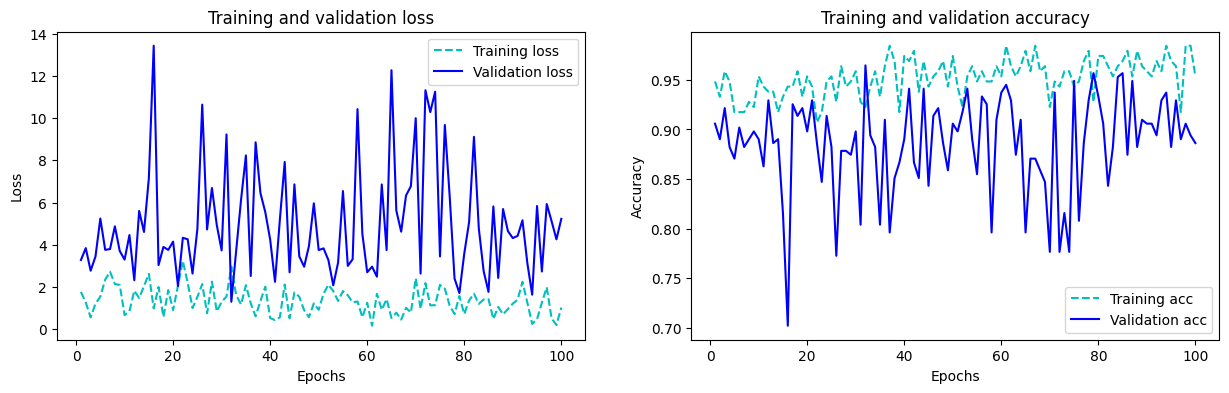

In [44]:
show_result(history_inceptionresnetv2__p_ghe_model)

In [45]:
inrn2_model_p_ghe = models.load_model('history_inceptionresnetv2__p_ghe_model.h5')
#all_test_df_p_ghe["label"] = all_test_df_p_ghe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(inrn2_model_p_ghe, test_set_p_ghe, all_test_df_p_ghe['label'])

In [121]:
result_p_ghe1 = inrn2_model_p_ghe.evaluate(test_set_p_ghe, verbose=0)
print("Test loss: {:.5f}".format(result_p_ghe1[0]))
print("Test accuracy: {:.2f}".format(result_p_ghe1[1]))

Test loss: 3.63746
Test accuracy: 0.89


### Model Xception

In [26]:
xcep_4 = xcep1_model

In [27]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_Xception1_p_ghe_model.h5', save_best_only=True, monitor='val_loss')

history_Xception1_p_ghe_model = xcep_4.fit(
                      training_set_p_ghe,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_p_ghe),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
49/49 [==============================] - 218s 4s/step - loss: 1.3945 - acc: 0.4794 - val_loss: 0.5032 - val_acc: 0.8078
Epoch 2/100
49/49 [==============================] - 155s 3s/step - loss: 0.8245 - acc: 0.6443 - val_loss: 0.5884 - val_acc: 0.7843
Epoch 3/100
49/49 [==============================] - 159s 3s/step - loss: 0.5895 - acc: 0.7216 - val_loss: 0.5260 - val_acc: 0.7922
Epoch 4/100
49/49 [==============================] - 130s 3s/step - loss: 0.5414 - acc: 0.8041 - val_loss: 0.6733 - val_acc: 0.7333
Epoch 5/100
49/49 [==============================] - 140s 3s/step - loss: 0.4359 - acc: 0.8247 - val_loss: 0.5159 - val_acc: 0.7961
Epoch 6/100
49/49 [==============================] - 145s 3s/step - loss: 0.3357 - acc: 0.8866 - val_loss: 0.5785 - val_acc: 0.7882
Epoch 7/100
49/49 [==============================] - 151s 3s/step - loss: 0.4285 - acc: 0.8454 - val_loss: 0.3293 - val_acc: 0.8745
Epoch 8/100
49/49 [==============================] - 146s 3s/step - loss: 0.

Highest validation accuracy in Epoch: 97
Train accuracy: 0.9484536051750183
Validation accuracy: 0.9529411792755127
--------------------------------------------------
Last train Epoch
Train accuracy: 0.938144326210022
Validation accuracy: 0.8627451062202454


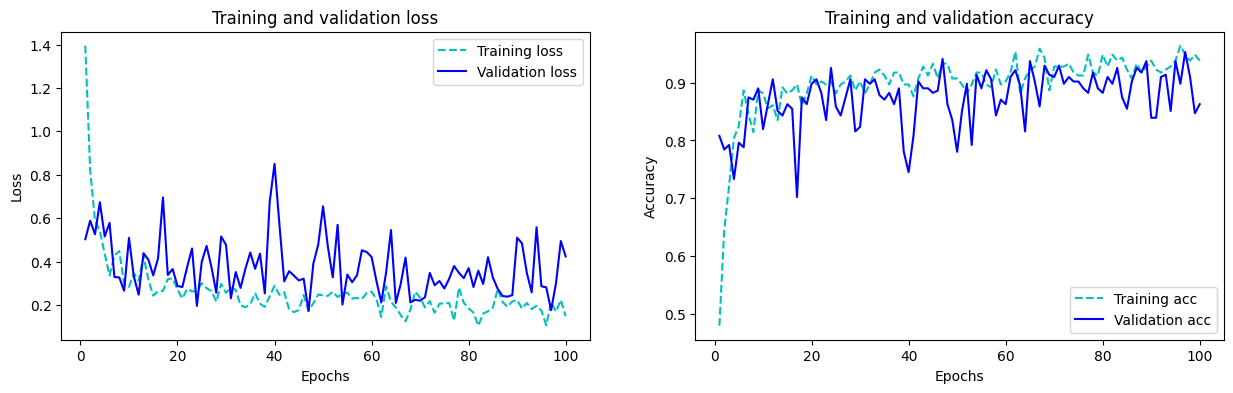

In [28]:
show_result(history_Xception1_p_ghe_model)

In [29]:
xcep_model_p_ghe = models.load_model('history_Xception1_p_ghe_model.h5')
#all_test_df_p_ghe["label"] = all_test_df_p_ghe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(xcep_model_p_ghe, test_set_p_ghe, all_test_df_p_ghe['label'])

In [30]:
result_p_ghe2 = xcep_model_p_ghe .evaluate(test_set_p_ghe, verbose=0)

print("Test loss: {:.5f}".format(result_p_ghe2[0]))
print("Test accuracy: {:.2f}".format(result_p_ghe2[1]))

Test loss: 0.47121
Test accuracy: 0.82


### Model efficientnetB2 

In [31]:
effi_4 = effi1_model

In [32]:
#mcp_save = ModelCheckpoint('history_efficientnet1_1_model_p_ghe.h5', save_best_only=True, monitor='val_loss')
history_efficientnetB2_p_ghe_model = effi_4.fit(
                      training_set_p_ghe,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_p_ghe)
                      #callbacks=[mcp_save]
                      )

Epoch 1/100
49/49 [==============================] - 188s 2s/step - loss: 1.0992 - acc: 0.3144 - val_loss: 1.1056 - val_acc: 0.0314
Epoch 2/100
49/49 [==============================] - 92s 2s/step - loss: 1.0988 - acc: 0.3351 - val_loss: 1.1077 - val_acc: 0.0314
Epoch 3/100
49/49 [==============================] - 95s 2s/step - loss: 1.0986 - acc: 0.3093 - val_loss: 1.1080 - val_acc: 0.1765
Epoch 4/100
49/49 [==============================] - 98s 2s/step - loss: 1.0984 - acc: 0.3093 - val_loss: 1.1038 - val_acc: 0.0314
Epoch 5/100
49/49 [==============================] - 97s 2s/step - loss: 1.0981 - acc: 0.3247 - val_loss: 1.1069 - val_acc: 0.2157
Epoch 6/100
49/49 [==============================] - 102s 2s/step - loss: 1.0982 - acc: 0.3196 - val_loss: 1.1068 - val_acc: 0.2157
Epoch 7/100
49/49 [==============================] - 104s 2s/step - loss: 1.0986 - acc: 0.3299 - val_loss: 1.1064 - val_acc: 0.2118
Epoch 8/100
49/49 [==============================] - 89s 2s/step - loss: 1.0991 

Highest validation accuracy in Epoch: 95
Train accuracy: 0.438144326210022
Validation accuracy: 0.529411792755127
--------------------------------------------------
Last train Epoch
Train accuracy: 0.42783504724502563
Validation accuracy: 0.5058823823928833


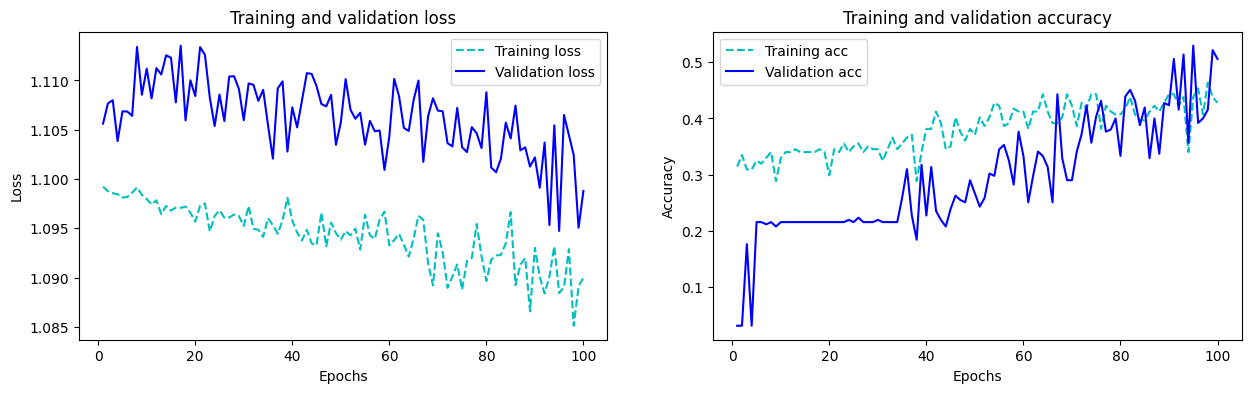

In [33]:
show_result(history_efficientnetB2_p_ghe_model)

In [34]:
effi_4.save('effi_p_ghe.h5')
effi_model_p_ghe = models.load_model('effi_p_ghe.h5')
result_p_ghe3  = effi_model_p_ghe.evaluate(test_set_p_ghe, verbose=0)

print("Test loss: {:.5f}".format(result_p_ghe3 [0]))
print("Test accuracy: {:.2f}".format(result_p_ghe3 [1]))
#result_p_ghe3 = history_efficientnetB2_1_model_p_ghe.evaluate(test_set_p_ghe, verbose=0)

#print("Test loss: {:.5f}".format(result_p_ghe3[0]))
#print("Test accuracy: {:.2f}".format(result_p_ghe3[1]))

Test loss: 1.08759
Test accuracy: 0.51


In [35]:
#effi_model_p_ghe = models.load_model('history_efficientnet1_1_model_p_ghe.h5')
#all_test_df_p_ghe["label"] = all_test_df_p_ghe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#

In [36]:
#predict_ef('C:\\Users\\CPE\\Desktop\\senior2023\\ossifying_fibroma.jpg',effi_model_p_ghe)

In [51]:
def predictor2(img, model):
    image = cv2.imread(img)
    image = cv2.resize(image, (260, 260))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 260,260,3)
    
    label_names = label_dict
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

1/1 [==============================] - 0s 89ms/step
The given image is of 
Class: 2 
Species: fi


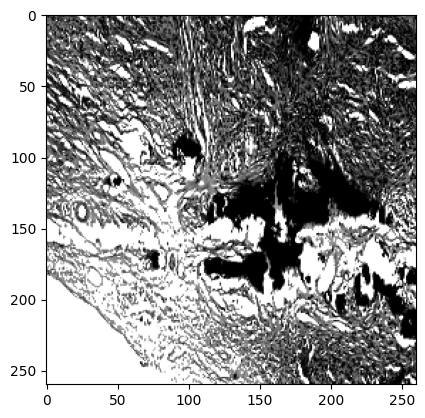

In [120]:
predictor2('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\os\\os_015_d.png',effi_model_p_ghe)

1/1 [==============================] - 0s 109ms/step
The given image is of 
Class: 2 
Species: fi


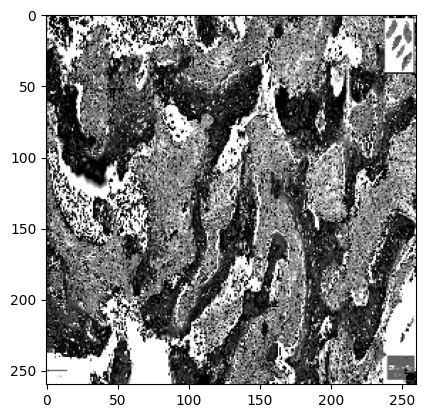

In [80]:
predictor2('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\fi\\fi_015_c.png',effi_model_p_ghe)

1/1 [==============================] - 0s 90ms/step
The given image is of 
Class: 2 
Species: fi


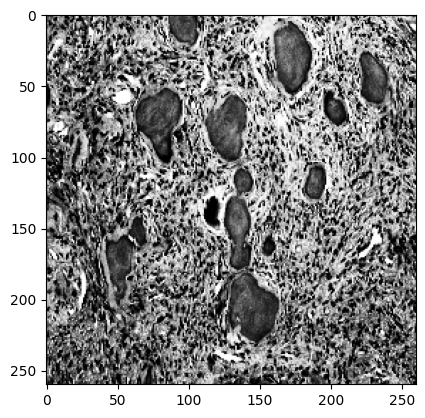

In [106]:
predictor2('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\ce\\ce_014_c.png',effi_model_p_ghe)